In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from mpl_toolkits.axes_grid1.colorbar import colorbar
matplotlib.rcParams['text.usetex'] = False
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
__imdir = '/home/oliver/PhD/Skill_Transfers/Warwick_Science_Day/'

## Results

In [2]:
def read_paramdict(majorlabel, minorlabel='', sort='astero'):
    '''Reads in results for either:
        -A full run series (majorlabel) where the minorlabel is included as a
            column in the output.
        -A single run (majorlabel and minorlabel).

        Returns a pandas dataframe.
    '''
    loc = __outdir__+majorlabel+'/'

    if minorlabel != '':
        globlist = glob.glob(loc+sort+'_'+str(float(minorlabel))+'_*pars*.csv')
    else:
        globlist = glob.glob(loc+sort+'*_*pars*.csv')

    minorlabels = [os.path.basename(globloc).split('_')[1] for globloc in globlist]
    if sort == 'gaia':
        ccdlabels = [os.path.basename(globloc).split('_')[-2] for globloc in globlist]
        
    df = pd.DataFrame()
    for n, globloc in enumerate(globlist):
        sdf = pd.read_csv(globloc, index_col = 0)
        if minorlabels[n] != 'pars.csv':
            sdf[majorlabel] = minorlabels[n]
            if sort == 'gaia':
                sdf['ccdlabel'] = ccdlabels[n]
        df = df.append(sdf)

    return df.sort_values(by=majorlabel)
import os
import glob
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/Paper_Output_2.0/'

## Errorbar method

In [3]:
yu_knoc = read_paramdict('K_tempscale_noCorrection')
yu_krc = read_paramdict('K_tempscale_Clump')
yu_knoc['tempscale'] = yu_knoc['K_tempscale_noCorrection'].str.strip()
yu_knoc['tempscale'] = yu_knoc.tempscale.astype(float)
yu_krc['tempscale'] = yu_krc['K_tempscale_Clump'].str.strip()
yu_krc['tempscale'] = yu_krc.tempscale.astype(float)

apo_knoc = read_paramdict('APOKASC_K_tempscale_noCorrection')
apo_krc = read_paramdict('APOKASC_K_tempscale_Clump')
apo_knoc['tempscale'] = apo_knoc['APOKASC_K_tempscale_noCorrection'].str.strip()
apo_knoc['tempscale'] = apo_knoc.tempscale.astype(float)
apo_krc['tempscale'] = apo_krc['APOKASC_K_tempscale_Clump'].str.strip()
apo_krc['tempscale'] = apo_krc.tempscale.astype(float)

# Asteroseismic Run

/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


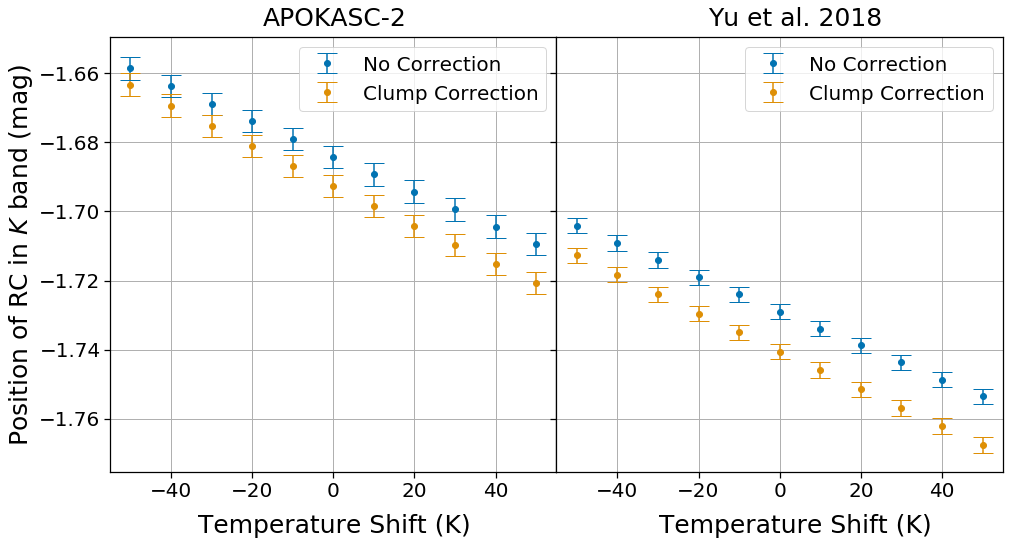

In [4]:
import matplotlib.gridspec as gridspec
cmap = sns.color_palette('colorblind')

fig = plt.figure(figsize=(16, 8))
gs0 = gridspec.GridSpec(1, 2, figure=fig,wspace=0.)
ax1 = plt.subplot(gs0[:, :1])
ax2 = plt.subplot(gs0[:, 1:],sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

ax1.grid()
ax1.set_axisbelow(True)
ax2.grid()
ax2.set_axisbelow(True)  

(_, caps1,_) = ax2.errorbar(yu_knoc.tempscale, yu_knoc.mu, yerr = yu_knoc.mu_std, fmt='o', capsize=10, label='No Correction')
(_, caps2,_) = ax2.errorbar(yu_krc.tempscale, yu_krc.mu, yerr = yu_krc.mu_std, fmt='o',  capsize=10,label='Clump Correction')
(_, caps3,_) = ax1.errorbar(apo_knoc.tempscale, apo_knoc.mu, yerr = apo_knoc.mu_std, fmt='o', capsize=10, label='No Correction')
(_, caps4,_) = ax1.errorbar(apo_krc.tempscale, apo_krc.mu, yerr = apo_krc.mu_std, fmt='o',  capsize=10,label='Clump Correction')
for cap1, cap2 in zip(caps1, caps2):
    cap1.set_markeredgewidth(1)
    cap2.set_markeredgewidth(1)

ax1.set_ylabel(r'Position of RC in $K$ band (mag)', fontsize=25)
fig.text(0.72, 0.9, r'Yu et al. 2018', ha='center', fontsize=25)
fig.text(0.32, 0.9, r"APOKASC-2", ha='center', fontsize=25)

fig.text(0.32, 0.02, r'Temperature Shift (K)', ha='center', fontsize=25)
fig.text(0.72, 0.02, r'Temperature Shift (K)', ha='center', fontsize=25)

ax1.legend(loc='upper right', fontsize='20')
ax2.legend(loc='upper right', fontsize='20')
plt.savefig(__imdir+'seismo_error.pdf')
plt.show()

## Violinplot method

In [5]:
def read_music(ml, kind, band, cnc, crc):
    chains = np.array([])
    tempscales = np.array([])
    ncrc = np.array([])

    for ts in np.arange(-50.,60.,10.):
        temp = str(ts)
        #Add NC chains & labels
        chain = np.genfromtxt(glob.glob(__outdir__+ml+'_'+cnc+'/'+kind+'_'+temp+'_chains.txt')[0])[0]
        chains = np.append(chains, chain)
        tempscales = np.append(tempscales, np.ones(len(chain))*ts)
        ncrc = np.append(ncrc, ['No Correction']*len(chain))

        #Add RC chains & labels
        chain = np.genfromtxt(glob.glob(__outdir__+ml+'_'+crc+'/'+kind+'_'+temp+'_chains.txt')[0])[0]
        chains = np.append(chains, chain)
        tempscales = np.append(tempscales, np.ones(len(chain))*ts)
        ncrc = np.append(ncrc, ['Clump Corrected']*len(chain))

    music = pd.DataFrame()
    music['chains'] = chains
    music['tempscales'] = tempscales
    music['ncrc'] = ncrc
    return music

In [6]:
mls = ['K_tempscale', 'APOKASC_K_tempscale']
kind = 'astero'
bands = ['K', 'GAIA']
cnc = 'noCorrection'
crc = 'Clump'
yukmusic = read_music(mls[0], kind, bands[0], cnc, crc)
apokmusic = read_music(mls[1], kind, bands[0], cnc, crc)

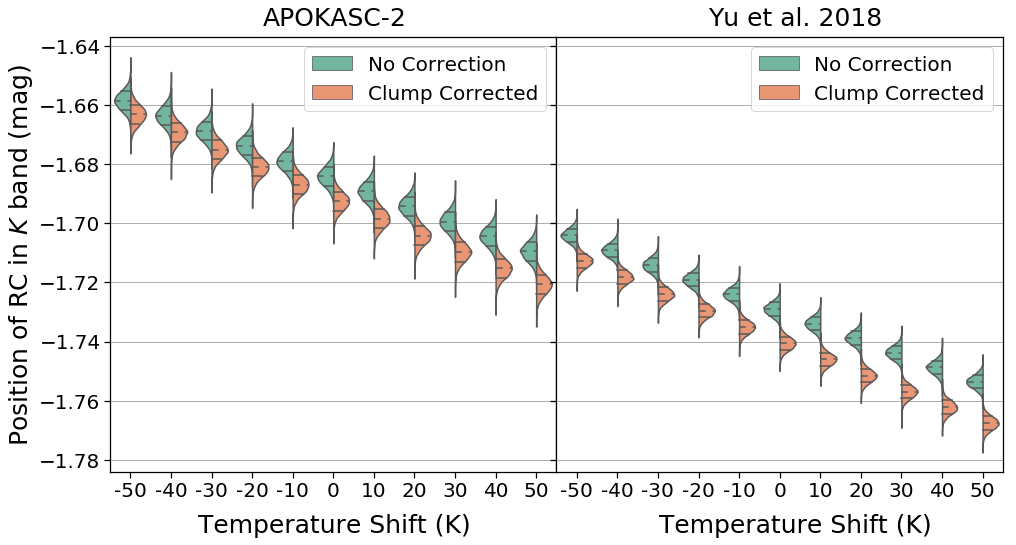

In [7]:
fig = plt.figure(figsize=(16, 8))
gs0 = gridspec.GridSpec(1, 2, figure=fig,wspace=0.)
ax1 = plt.subplot(gs0[:, :1])
ax2 = plt.subplot(gs0[:, 1:],sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

ax1.grid()
ax1.set_axisbelow(True)
ax2.grid()
ax2.set_axisbelow(True)  

sns.violinplot(apokmusic.tempscales.astype(int).values, apokmusic.chains.values, hue=apokmusic.ncrc.values,
                    palette='Set2',split=True, inner='quartile', ax = ax1)

sns.violinplot(yukmusic.tempscales.astype(int).values, yukmusic.chains.values, hue=yukmusic.ncrc.values,
                palette='Set2',split=True, inner='quartile', ax = ax2)

ax1.set_ylabel(r'Position of RC in $K$ band (mag)', fontsize=25)
fig.text(0.72, 0.9, r'Yu et al. 2018', ha='center', fontsize=25)
fig.text(0.32, 0.9, r"APOKASC-2", ha='center', fontsize=25)

fig.text(0.32, 0.02, r'Temperature Shift (K)', ha='center', fontsize=25)
fig.text(0.72, 0.02, r'Temperature Shift (K)', ha='center', fontsize=25)

ax1.legend(loc='upper right', fontsize='20')
ax2.legend(loc='upper right', fontsize='20')

plt.savefig(__imdir+'seismo_violin.pdf')
plt.savefig(__imdir+'seismo_violin.png')

plt.show()

# Gaia run using seismic priors

## Errorbar Method

In [8]:
yu_krc = read_paramdict('Gaia_K_tempscale_Clump',sort='gaia')

yu_krc['tempscale'] = yu_krc['Gaia_K_tempscale_Clump'].str.strip()
yu_krc['tempscale'] = yu_krc.tempscale.astype(float)

apo_krc = read_paramdict('Gaia_APOKASC_K_tempscale_Clump',sort='gaia')
apo_krc['tempscale'] = apo_krc['Gaia_APOKASC_K_tempscale_Clump'].str.strip()
apo_krc['tempscale'] = apo_krc.tempscale.astype(float)

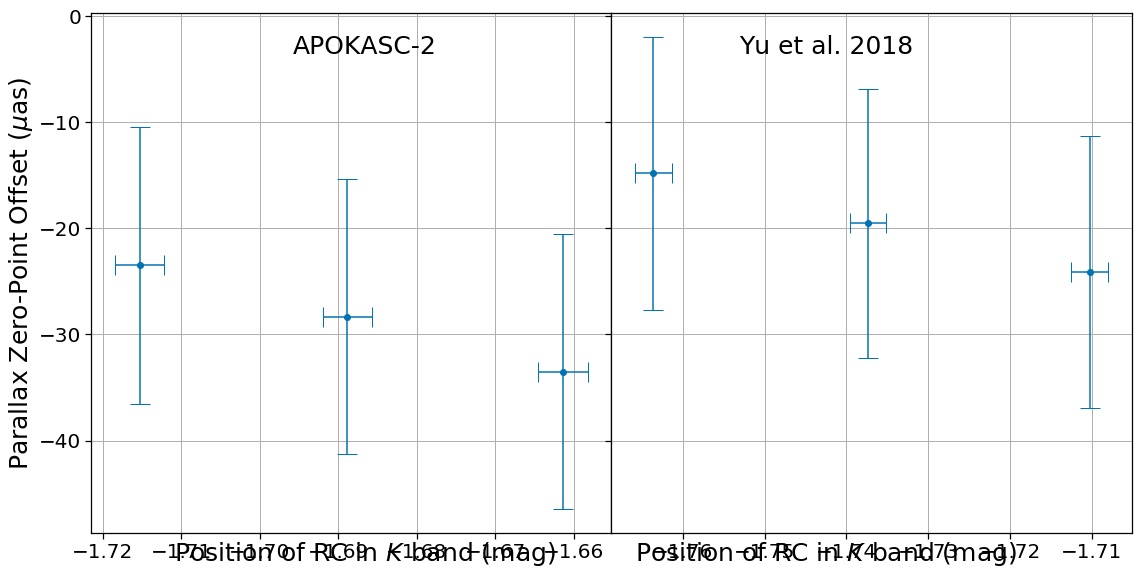

In [9]:
fig = plt.figure(figsize=(16, 8))
gs0 = gridspec.GridSpec(1, 2, figure=fig,wspace=0.)
ax1 = plt.subplot(gs0[:, :1])
ax2 = plt.subplot(gs0[:, 1:],sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

ax1.grid()
ax1.set_axisbelow(True)
ax2.grid()
ax2.set_axisbelow(True)  

(_, caps2,_) = ax2.errorbar(yu_krc.mu, yu_krc.oo_zp, yerr = yu_krc.oo_zp_std, xerr = yu_krc.mu_std, fmt='o',  capsize=10,label='Clump Correction')
(_, caps4,_) = ax1.errorbar(apo_krc.mu, apo_krc.oo_zp, yerr = apo_krc.oo_zp_std, xerr = apo_krc.mu_std, fmt='o',  capsize=10,label='Clump Correction')
for cap1, cap2 in zip(caps1, caps2):
    cap1.set_markeredgewidth(1)
    cap2.set_markeredgewidth(1)

ax1.set_ylabel(r'Parallax Zero-Point Offset ($\mu \rm as$)', fontsize=25)
fig.text(0.72, 0.9, r'Yu et al. 2018', ha='center', fontsize=25)
fig.text(0.32, 0.9, r"APOKASC-2", ha='center', fontsize=25)

fig.text(0.32, 0.02, r'Position of RC in $K$ band (mag)', ha='center', fontsize=25)
fig.text(0.72, 0.02, r'Position of RC in $K$ band (mag)', ha='center', fontsize=25)
fig.tight_layout()
plt.savefig(__imdir+'gaia_error.pdf')
plt.show()

## Violinplot Method

In [10]:
def read_music(mls):
    chains = np.array([])
    tempscales = np.array([])
    rcmag = np.array([])
    source = np.array([])
    sources = ['Yu+2018','APOKASC-2']
    cols = ['Left','Right']
    col = np.array([])
        
    for idx, ml in enumerate(mls):
        for ts in np.arange(-50.,100.,50.):
            temp = str(ts)

            #Add RC chains & labels
            try:
                chain = np.genfromtxt(__outdir__+ml+'/'+'gaia_'+temp+'_chains.txt')[-1]
                chains = np.append(chains, chain)
                tempscales = np.append(tempscales, np.ones(len(chain))*ts)

                mu = np.round(pd.read_csv(__outdir__+ml+'/'+'gaia_'+temp+'_pars.csv')['mu'].values[0],2)
                rcmag = np.append(rcmag, np.ones(len(chain))*mu)
                
                source = np.append(source, [sources[idx]]*len(chain))
                col = np.append(col, [cols[idx]]*len(chain))
                
            except IOError:
                popt = get_slopes(mls, ccd)
                mu_wanted = np.round(pd.read_csv(__outdir__+ml.replace('Gaia_','')+'/'+'astero_'+temp+'_pars.csv')['mu'].values[0],2)
                oozp_wanted = popt[0]*mu_wanted + popt[1]
                oozp_base = pd.read_csv(__outdir__+mls[0]+'/'+'gaia_-50.0_pars.csv')['oo_zp'].values[0]
                diff = oozp_wanted - oozp_base
                chain = np.genfromtxt(__outdir__+mls[0]+'/'+'gaia_-50.0_chains.txt')[-1]
                
                chains = np.append(chains, chain+diff)
                rcmag = np.append(rcmag, np.ones(len(chain))*mu_wanted)
                source = np.append(source, ['Extrapolated']*len(chain))
                tempscales = np.append(tempscales, np.ones(len(chain))*ts)
                col = np.append(col, [cols[idx]]*len(chain))

    music = pd.DataFrame()
    music['chains'] = chains
    music['tempscales'] = tempscales
    music['rcmag'] = rcmag
    music['source'] = source
    music['col'] = col

    return music

In [11]:
mlk = ['Gaia_K_tempscale_Clump', 'Gaia_APOKASC_K_tempscale_Clump']
kmusic = read_music(mlk)
kyu = kmusic[kmusic.source == 'Yu+2018']
kapo = kmusic[kmusic.source == 'APOKASC-2']

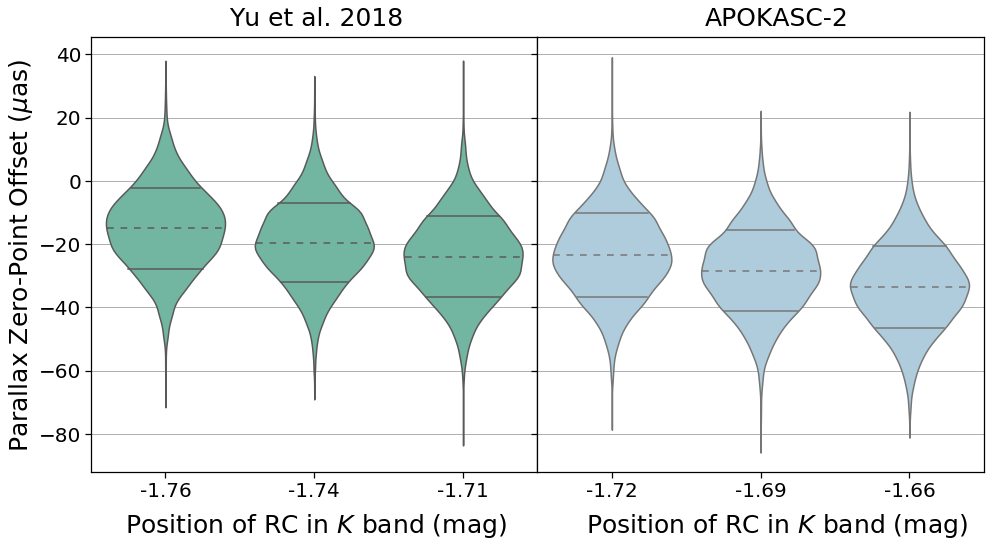

In [12]:
fig = plt.figure(figsize=(16, 8))
gs0 = gridspec.GridSpec(1, 2, figure=fig,wspace=0.)
ax1 = plt.subplot(gs0[:, :1])
ax2 = plt.subplot(gs0[:, 1:],sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

ax1.grid()
ax1.set_axisbelow(True)
ax2.grid()
ax2.set_axisbelow(True)  

sns.violinplot(kyu.rcmag.values, kyu.chains.values,
                    palette='Set2', hue = kyu.source.values, dodge=False, inner='quartile',ax=ax1)
sns.violinplot(kapo.rcmag.values, kapo.chains.values,
                    palette='Paired', hue = kapo.source.values, dodge=False, inner='quartile',ax=ax2)

ax1.set_ylabel(r'Parallax Zero-Point Offset ($\mu \rm as$)', fontsize=25)
fig.text(0.32, 0.9, r'Yu et al. 2018', ha='center', fontsize=25)
fig.text(0.72, 0.9, r"APOKASC-2", ha='center', fontsize=25)

fig.text(0.32, 0.02, r'Position of RC in $K$ band (mag)', ha='center', fontsize=25)
fig.text(0.72, 0.02, r'Position of RC in $K$ band (mag)', ha='center', fontsize=25)

ax1.get_legend().remove()
ax2.get_legend().remove()
plt.savefig(__imdir+'gaia_violin.pdf')
plt.show()

# Gaia run using Literature Priors

In [13]:
oozps = pd.DataFrame(index=['Lindegren','Zinn','Riess','Sahlholdt','Stassun','Hawkins','Uninformed'],
                     columns=['mu','spread'])
oozps.loc['Lindegren']['mu'] = -29.
oozps.loc['Lindegren']['spread'] = 1.
oozps.loc['Zinn']['mu'] = -52.8
oozps.loc['Zinn']['spread'] = 3.4
oozps.loc['Riess']['mu'] = -46.
oozps.loc['Riess']['spread'] = 13.
oozps.loc['Sahlholdt']['mu'] = -35.
oozps.loc['Sahlholdt']['spread'] = 16.
oozps.loc['Stassun']['mu'] = -82.
oozps.loc['Stassun']['spread'] = 33.
oozps.loc['Hawkins']['mu'] = 0.
oozps.loc['Hawkins']['spread'] = 1.
# oozps.loc['Uninformed']['mu'] = 0.
# oozps.loc['Uninformed']['spread'] = 1000.
# oozps.loc['Khan']['mu'] = -47.02
# oozps.loc['Khan']['spread'] = 0.80

In [14]:
loc = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'+'Parallax_Runs/Highruns'
indices = oozps.index.values

df = pd.DataFrame()
for idx in indices:
    sdf = pd.read_csv(loc+'K_'+idx+'_pars.csv',index_col=0)
    sdf['Source'] = idx
    df = df.append(sdf)

IOError: File /home/oliver/PhD/Gaia_Project/Output/Parallax_Runs/HighrunsK_Lindegren_pars.csv does not exist

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.grid()
ax.set_axisbelow(True)

modindices = ['Lindegren','Zinn','Riess','Sahlholdt & Silva Aguirre','Stassun & Torres','None','Uninformed']

ax.set_ylabel(r'Position of RC in $K$ band (mag)', fontsize=25)
ax.set_xlabel(r'Literature Parallax Zero-Point ($\mu \rm as$)',fontsize=25)
for n, idx in enumerate(oozps.index.values):
    if idx == 'Uninformed':
        sel = df['Source'] == idx
        (_, caps, _) = ax.errorbar(df[sel].oo_zp,df[sel]['mu'],
                        yerr=df[sel]['mu_std'], xerr=df[sel].oo_zp_std,
                        linewidth=4., capsize=10, zorder=2,c='r',label=None)
        ax.scatter(df[sel].oo_zp, df[sel].mu, marker='*',s=800, c='r', label=modindices[n],zorder=10, edgecolor='k')
    else:
        sel = df['Source'] == idx
        (_, caps, _) = ax.errorbar(oozps.loc[idx]['mu'],df[sel]['mu'],
                        yerr=df[sel]['mu_std'], xerr=oozps.loc[idx]['spread'],
                        linewidth=3., capsize=10, label=modindices[n], zorder=1)
    for cap in caps:
        cap.set_markeredgewidth(1)
ax.legend(loc='lower center', fontsize=20,ncol=4, bbox_to_anchor=(.5, .05))
fig.tight_layout()
plt.savefig(__imdir+'paralalx_error.pdf')
plt.show()

# Inference of seismology from Gaia

In [ ]:
yu_knoc = read_paramdict('K_tempscale_noCorrection')
yu_krc = read_paramdict('K_tempscale_Clump')
yu_knoc['tempscale'] = yu_knoc['K_tempscale_noCorrection'].str.strip()
yu_knoc['tempscale'] = yu_knoc.tempscale.astype(float)
yu_krc['tempscale'] = yu_krc['K_tempscale_Clump'].str.strip()
yu_krc['tempscale'] = yu_krc.tempscale.astype(float)
yu_knoc = yu_knoc.sort_values('tempscale')
yu_krc = yu_krc.sort_values('tempscale')

apo_knoc = read_paramdict('APOKASC_K_tempscale_noCorrection')
apo_krc = read_paramdict('APOKASC_K_tempscale_Clump')
apo_knoc['tempscale'] = apo_knoc['APOKASC_K_tempscale_noCorrection'].str.strip()
apo_knoc['tempscale'] = apo_knoc.tempscale.astype(float)
apo_krc['tempscale'] = apo_krc['APOKASC_K_tempscale_Clump'].str.strip()
apo_krc['tempscale'] = apo_krc.tempscale.astype(float)
apo_knoc = apo_knoc.sort_values('tempscale')
apo_krc = apo_krc.sort_values('tempscale')

__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'
df = pd.read_csv(__datdir__+'rcxyu18.csv')
apo = pd.read_csv(__datdir__+'rcxyuxapokasc2.csv')
yumedt = np.array([np.mean(df.Teff+dt) for dt in np.arange(-50,60,10)])
apomedt = np.array([np.mean(apo.Teff+dt) for dt in np.arange(-50, 60,10)])

In [ ]:
#Lets fit some lines
fig = plt.figure()
x0 = np.linspace(4600, 5000, 1000)
p0 = np.zeros(4)
p1 = np.zeros(4)
for idx, frame in enumerate([yu_knoc, yu_krc, apo_knoc, apo_krc]):
    if idx < 2:
        medt = yumedt
    else:
        medt = apomedt
    A = np.vander(medt, 2)
    y = frame.mu.values
    yerr = frame.mu_std.values
    p = np.linalg.solve(np.dot(A.T, A/yerr[:, None]**2), np.dot(A.T, y/yerr**2))
    p0[idx] = p[0]
    p1[idx] = p[1]

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.grid()
ax1.set_axisbelow(True)  

(_, caps1,_) = ax1.errorbar(yumedt, yu_knoc.mu, yerr = yu_knoc.mu_std, fmt='o', elinewidth=3,
                            capsize=10, label='No Correction')
(_, caps2,_) = ax1.errorbar(yumedt, yu_krc.mu, yerr = yu_krc.mu_std, fmt='*',  elinewidth=3,
                            capsize=10,label='Clump Correction')
(_, caps3,_) = ax1.errorbar(apomedt, apo_knoc.mu, yerr = apo_knoc.mu_std, fmt='o', elinewidth=3,
                            capsize=10, label='No Correction')
(_, caps4,_) = ax1.errorbar(apomedt, apo_krc.mu, yerr = apo_krc.mu_std, fmt='*',  elinewidth=3,
                            capsize=10,label='Clump Correction')

mumax = -1.634 + 0.017
mumin = -1.634 - 0.017
idx = 0
for pzero, pone in zip(p0, p1):
    line = x0*pzero + pone
    tmin = (mumax - pone)/pzero
    tmax = (mumin - pone)/pzero
    ax1.plot(x0, x0*pzero + pone,linestyle='-.', lw=2,c='k',alpha=.5)
    xfill = np.linspace(x0.min(), tmin,100)
    linefill = xfill*pzero + pone
    ax1.fill_between(xfill, np.ones(len(xfill))*mumin, np.ones(len(xfill))*mumax, interpolate=True, alpha=.1, color='r')
    
    xfill = np.linspace(tmin, tmax, 100)
    linefill = xfill*pzero + pone
    ax1.fill_between(xfill, np.ones(len(xfill))*-1.80, linefill, alpha=.1, interpolate=True, color='r')
    
    if idx < 2:
        print('Mean shift correspond to a temperature of: {} K'.format(np.mean(xfill)-np.mean(df.Teff)))
    else:
        print('Mean shift correspond to a temperature of: {} K'.format(np.mean(xfill)-np.mean(apo.Teff)))
    idx += 1
print('Difference in means from Yu to Apo: {} K'.format(np.mean(df.Teff - np.mean(apo.Teff))))
print('Difference in means from Yu to Apo subsamples: {} K'.format(np.mean(apo.Yu_Teff - np.mean(apo.Teff))))

    
ax1.set_ylabel(r'Position of RC in $K$ band (mag)', fontsize=25)
fig.text(0.75, 0.9, r'Yu et al. 2018', ha='center', fontsize=25)
fig.text(0.43, 0.9, r"APOKASC-2", ha='center', fontsize=25)

ax1.set_xlabel(r'Mean Temperature of run sample ($K$)',fontsize=25)

ax1.legend(loc='upper right', fontsize='20')
ax1.set_xlim(x0.min(), x0.max())
ax1.set_ylim(-1.78, -1.60)
fig.tight_layout()
plt.savefig(__imdir+'calibration.pdf')
plt.show()

# KASC/TASC Graveyard

## Asteroseismic model

In [ ]:
df = pd.read_csv('../../data/KepxDR2/rcxyu18.csv')
df.head(1)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
c=ax.scatter(df.ra, df.dec, s=df.parallax*80, c=df.Kmag,cmap='viridis_r')
plt.xlabel('RA')
plt.ylabel('Dec')
fig.colorbar(c, label='K-band apparent magnitude')
fig.tight_layout()
plt.title('Total # Stars: '+str(len(df)),fontsize=25)
plt.savefig('data_field.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(df['ast_Mbol'], ax = ax)
plt.xlabel('Seismic Absolute K-band Magnitude')
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('seismic_kmag.png')
plt.show()

In [ ]:
def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))
rmu = -1.7
rsigma = .1
rsigo = 4. * rsigma
rQ = .85

x = np.linspace(-3, -0.5, len(df))
fg = normal(x, rmu, rsigma)
bg = normal(x, rmu, rsigo)
ll = rQ * fg + (1-rQ) * bg

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, fg,  linestyle='--', label='RC')
ax.plot(x, bg, linestyle='--', label='Outliers')
ax.plot(x, ll, label = 'Model')
ax.legend(loc='best', fontsize=20)

plt.yticks([])
plt.xlabel('Seismic Absolute K-band Magnitude')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('mixmod.png')

plt.show()

In [ ]:
from tqdm import tqdm
def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

x = np.linspace(-3.0, -0.5, 100)
fig, ax = plt.subplots(figsize=(6,6))
for idx in tqdm(range(len(df[:20]))):
    ax.plot(x, normal(x, df['ast_MKs'][idx], df['ast_M_err'][idx]),alpha=.75)

plt.yticks([])
plt.xlabel('Seismic Absolute K-band Magnitude')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('infM.png')

plt.show()

In [ ]:
df.ast_M_err[0]

HR Diagram

In [ ]:
df = pd.read_csv('../../data/TRILEGAL_sim/k1.6b_K15b30_0910_new.all.out.txt',sep = '\s+')
df = df[:]
print(list(df))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(3.7,1.52,facecolor=None)
ax.scatter(df['logg'], df['logL'],c=df.stage,s=1)
# df_rc = df[(df.stage == 4) | (df.stage == 5) | (df.stage == 6)]
# ax.scatter(df_rc['logg'], df_rc['logL'],s=2)

# axins = inset_axes(ax, width='33%', height='33%',loc=3, borderpad=6.)
# Telo, Tehi = 3.64, 3.72
# Llo, Lhi = 1.52, 2.1
# df_in = df[(df.logTe > Telo) & (df.logTe < Tehi) & (df.logL > Llo) & (df.logL < Lhi)]
# sel = (df_in.stage.values == 4) | (df_in.stage.values == 5) | (df_in.stage.values == 6)
# axins.scatter(df_in.logTe[~sel], df_in.logL[~sel], s=5, c='k',alpha=.01)
# c = axins.scatter(df_in.logTe[sel], df_in.logL[sel], s=5, c=df_in.Mact[sel], cmap='viridis')

# cax = inset_axes(axins,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="100%",  # height : 50%
#                  loc=3,
#                  bbox_to_anchor=(1.05, 0., 1, 1),
#                  bbox_transform=axins.transAxes,
#                  borderpad=0,
#                  )
# fig.colorbar(c, cax=cax, label=r'$M (M_\odot)$')
# axins.invert_xaxis()

# patch, pp1, pp2 = mark_inset(ax, axins, loc1=4, loc2=1, lw=1, ec='k', fc='none')
# pp1.loc1 = 2
# pp1.loc2 = 1
# pp2.loc1 = 1
# pp2.loc2 = 2

# ax.set_xlabel(r'$log(T_{\rmeff} (K)$)')
# ax.set_ylabel(r'$log(L)(L_\odot)$')
# ax.set_title(r'TRILEGAL HR Diagram | Subset: Core He Burning coloured by Mass',fontsize=20)
# ax.invert_xaxis()
# plt.savefig('HRdiagram.png')
plt.show()